In [153]:
# Imports
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import uuid
import mlflow
import mlflow.sklearn

from datetime import datetime

from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, root_mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [154]:
# Directory config to project root to insure consistency across environments for project specific imports
from pyprojroot import here
os.chdir(here())

# Project specific imports
from src.utils import save_dataframe

In [155]:
target = 'revenue'

In [156]:
# Load dataset
data = pd.read_csv("./data/1.1_imputed_data_full.csv")

# Data filters
data = data.dropna(subset=['revenue'])
# data = data[data["budget_missing"] == 0]
# data = data[data["revenue_missing"] == 0]
# data = data[data["budget_missing"] == 0 & data["revenue_missing"] == 0]
# data = data[(data["budget_missing"] == 0) & (data["revenue_missing"] == 0)]

# Split X/y
# X = data.drop(columns=[target])
X = data.drop(columns=[target, 'revenue_missing'])
y = data[target]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
# X_train.info()

In [158]:
# # Load dataset
# data = pd.read_csv("./data/1.2_imputed_data_no_revenue.csv")

# # Data filters
# data = data.dropna(subset=['revenue'])
# # data = data[data["budget_missing"] == 0]
# # data = data[data["revenue_missing"] == 0]
# # data = data[data["budget_missing"] == 0 & data["revenue_missing"] == 0]
# # data = data[(data["budget_missing"] == 0) & (data["revenue_missing"] == 0)]

# # Split X/y
# X = data.drop(columns=[target])
# y = data[target]

# # Train/Test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
# X_train.info()

In [160]:
# X_train = pd.read_csv("./data/1.3.1_X_train_imputed.csv")
# X_test = pd.read_csv("./data/1.3.2_X_test_imputed.csv")
# y_train = pd.read_csv("./data/1.3.3_y_train.csv")
# y_test = pd.read_csv("./data/1.3.4_y_test.csv")

In [161]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7192 entries, 3846 to 7270
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   metascore                       7192 non-null   float64
 1   rotten_tomatoes_rating          7192 non-null   float64
 2   meta_critic_rating              7192 non-null   float64
 3   budget                          7192 non-null   float64
 4   metascore_missing               7192 non-null   int64  
 5   rotten_tomatoes_rating_missing  7192 non-null   int64  
 6   meta_critic_rating_missing      7192 non-null   int64  
 7   budget_missing                  7192 non-null   int64  
 8   total_wins                      7192 non-null   int64  
 9   total_noms                      7192 non-null   int64  
 10  oscar_wins                      7192 non-null   int64  
 11  oscar_noms                      7192 non-null   int64  
 12  bafta_wins                      7192

In [162]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 7192 entries, 3846 to 7270
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
7192 non-null   float64
dtypes: float64(1)
memory usage: 112.4 KB


## Multilable Binarizer

In [163]:
def apply_mlb_for_feature(df: pd.DataFrame, feature: str, delimiter: str = ",") -> pd.DataFrame:
    """
    Applies MultiLabelBinarizer to a single multi-label column and returns a new DataFrame 
    with the original column replaced by its one-hot encoded dummy columns.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature (str): The name of the column to encode.
        delimiter (str): The delimiter used in the column to separate values (default: ", ").
    
    Returns:
        pd.DataFrame: A new DataFrame with the specified feature replaced by one-hot encoded columns.
    """
    df = df.copy()
    
    # Create a new column that is a list of values from the original column
    list_col = feature + "_list"
    df[list_col] = df[feature].apply(lambda x: [i.strip().replace(' ', '_') for i in x.split(delimiter)] if pd.notnull(x) else [])
    
    # Initialize and fit MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    dummies = pd.DataFrame(
        mlb.fit_transform(df[list_col]),
        columns=[f"{feature}_{cls}" for cls in mlb.classes_],
        index=df.index
    )
    
    # Concatenate the dummy columns to the DataFrame and drop the original columns
    df = pd.concat([df, dummies], axis=1).drop([feature, list_col], axis=1)
    return df

# Function to apply MultiLabelBinarizer for multiple features
def apply_mlb_for_features(df: pd.DataFrame, features: list, delimiter: str = ",") -> pd.DataFrame:
    for feature in features:
        df = apply_mlb_for_feature(df, feature, delimiter)
    return df

# List of multi-label features
mlb_features = ['genre_names', 'production_country_name', 'spoken_languages']

# Create a FunctionTransformer
mlb_transformer = FunctionTransformer(func=apply_mlb_for_features, kw_args={'features': mlb_features})

In [164]:
import pandas as pd
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer that applies MultiLabelBinarizer to a specified column.
    It splits the column values using a delimiter, replaces spaces with underscores,
    fits a MultiLabelBinarizer during fit, and transforms new data using the learned classes.
    
    Parameters
    ----------
    column : str
        The name of the column to encode.
    delimiter : str, default=","
        The delimiter used in the column to separate values.
    prefix : str, optional
        The prefix for the dummy columns. If None, uses the column name.
    """
    def __init__(self, column, delimiter=",", prefix=None):
        self.column = column
        self.delimiter = delimiter
        self.prefix = prefix if prefix is not None else column
        self.mlb_ = None
        
    def fit(self, X, y=None):
        X = X.copy()
        # Convert the column values into lists
        list_col = X[self.column].apply(
            lambda x: [i.strip().replace(' ', '_') for i in x.split(self.delimiter)] if pd.notnull(x) else []
        )
        self.mlb_ = MultiLabelBinarizer()
        self.mlb_.fit(list_col)
        return self
    
    def transform(self, X):
        X = X.copy()
        # Convert column values into lists as in fit
        list_col = X[self.column].apply(
            lambda x: [i.strip().replace(' ', '_') for i in x.split(self.delimiter)] if pd.notnull(x) else []
        )
        dummies = pd.DataFrame(
            self.mlb_.transform(list_col),
            columns=[f"{self.prefix}_{cls}" for cls in self.mlb_.classes_],
            index=X.index
        )
        # Drop the original column and add the dummies.
        X = X.drop(columns=[self.column])
        X = pd.concat([X, dummies], axis=1)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return [f"{self.prefix}_{cls}" for cls in self.mlb_.classes_]

# To apply this transformer for multiple columns in a ColumnTransformer:
from sklearn.compose import ColumnTransformer

mlb_features = ['genre_names', 'production_country_name', 'spoken_languages']

transformers = [
    (f"mlb_{feat}", MultiLabelBinarizerTransformer(column=feat, delimiter=","), [feat])
    for feat in mlb_features
]

mlb = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Set output to pandas dataframe
mlb.set_output(transform='pandas')

# # Now, when you call ct.fit_transform(data), each specified column will be
# # transformed consistently with the same feature names.
# transformed_data = ct.fit_transform(data)
# # If needed, convert back to a DataFrame (if not already one):
# if not isinstance(transformed_data, pd.DataFrame):
#     # You can combine the new feature names with the remainder columns' names.
#     # For simplicity, here we assume the output is a DataFrame.
#     transformed_data = pd.DataFrame(transformed_data)
    
# print(transformed_data.head())


ColumnTransformer(remainder='passthrough',
                  transformers=[('mlb_genre_names',
                                 MultiLabelBinarizerTransformer(column='genre_names',
                                                                prefix='genre_names'),
                                 ['genre_names']),
                                ('mlb_production_country_name',
                                 MultiLabelBinarizerTransformer(column='production_country_name',
                                                                prefix='production_country_name'),
                                 ['production_country_name']),
                                ('mlb_spoken_languages',
                                 MultiLabelBinarizerTransformer(column='spoken_languages',
                                                                prefix='spoken_languages'),
                                 ['spoken_languages'])],
                  verbose_feature_names_out=False)

In [165]:
num_cols = make_column_selector(dtype_include=['number'])
num_cols = num_cols(data)

for col in num_cols:
    print(col)

metascore
rotten_tomatoes_rating
meta_critic_rating
budget
revenue
metascore_missing
rotten_tomatoes_rating_missing
meta_critic_rating_missing
budget_missing
revenue_missing
total_wins
total_noms
oscar_wins
oscar_noms
bafta_wins
bafta_noms
release_year
release_month
release_day
is_weekend
is_holiday_season
movie_age
imdb_rating
imdb_votes
tmdb_vote_count
tmdb_vote_average
runtime_in_min
tmdb_popularity


In [166]:
cat_cols = make_column_selector(dtype_include=['object'])
cat_cols = cat_cols(data)

# for col in cat_cols:
#     print(col)

print(cat_cols)

['release_date', 'production_country_name', 'spoken_languages', 'first_billing_actor', 'second_billing_actor', 'third_billing_actor', 'main_director', 'main_writer', 'secondary_writer', 'title', 'genre_names', 'production_company_name', 'age_rating']


In [167]:
# ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# ohe.set_output(transform="default")

# scaler = StandardScaler()

In [168]:
modeling_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [
            'metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'tmdb_vote_count', 'tmdb_vote_average', 'runtime_in_min', 
            'tmdb_popularity', 'imdb_rating', 'imdb_votes', 'total_wins', 'total_noms', 'oscar_wins', 'oscar_noms', 'bafta_wins', 'bafta_noms', 
            'release_year', 'release_month', 'release_day', 'movie_age', 
            # 'roi', 'revenue'
            ]),
        ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['age_rating']),
        ('OrdinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999999), ['first_billing_actor', 'second_billing_actor', 'third_billing_actor', 'main_director', 'main_writer', 'secondary_writer'])
    ],
    remainder='passthrough', 
    verbose_feature_names_out=False,
)

# Set output to pandas dataframe
modeling_transformer.set_output(transform='pandas')

# transformed_data = modeling_transformer.fit_transform(data)
# transformed_data.head()

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['metascore', 'rotten_tomatoes_rating',
                                  'meta_critic_rating', 'budget',
                                  'tmdb_vote_count', 'tmdb_vote_average',
                                  'runtime_in_min', 'tmdb_popularity',
                                  'imdb_rating', 'imdb_votes', 'total_wins',
                                  'total_noms', 'oscar_wins', 'oscar_noms',
                                  'bafta_wins', 'bafta_noms', 'release_year',
                                  'relea...',
                                  'movie_age']),
                                ('OneHotEncoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['age_rating']),
                                ('OrdinalEncoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=999999),
                                 ['first_billing_actor', 'second_billing_actor',
                                  'third_billing_actor', 'main_director',
                                  'main_writer', 'secondary_writer'])],
                  verbose_feature_names_out=False)

In [169]:
# Define a function transformer to drop unwanted columns.
def drop_unwanted_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    return df.drop(columns=columns, errors='ignore')

columns_to_drop = ['production_company_name', 'director', 'writer', 'actors', 'title', 'release_date']

dropper = FunctionTransformer(drop_unwanted_columns, kw_args={'columns': columns_to_drop})

In [170]:
scaling_pipeline = Pipeline(steps=[
    ('modeling_transformer', modeling_transformer),
    # ('mlb', mlb_transformer),
    ('mlb', mlb),
    ('dropper', dropper)
])

# scaled_data = scaling_pipeline.fit_transform(data)
# scaled_data.info()

In [171]:
# scaled_data.head()

In [172]:
# Saving cleaned dataset for future use
# save_dataframe(scaled_data, "03_modeling_data.csv")

In [173]:
# target = 'revenue'
# X = data.drop(columns=[target])
# y = data[target]

In [174]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [175]:
# Fit the pipeline on the training data
X_train_scaled = scaling_pipeline.fit_transform(X_train, y_train)

# Transform the test data using the same pipeline
X_test_scaled = scaling_pipeline.transform(X_test)

In [176]:
X_train_scaled.head()

,genre_names_Action,genre_names_Adventure,genre_names_Animation,genre_names_Comedy,genre_names_Crime,genre_names_Documentary,genre_names_Drama,genre_names_Family,genre_names_Fantasy,genre_names_History,...,third_billing_actor,main_director,main_writer,secondary_writer,metascore_missing,rotten_tomatoes_rating_missing,meta_critic_rating_missing,budget_missing,is_weekend,is_holiday_season
3846,0,0,0,0,1,0,1,0,0,0,...,975.0,1750.0,607.0,1979.0,1,1,1,0,0,1
2088,0,1,0,1,0,0,0,0,0,0,...,2353.0,3090.0,4122.0,3606.0,0,0,0,0,1,0
435,0,0,0,0,0,0,0,0,0,0,...,4788.0,1032.0,764.0,1427.0,0,0,0,0,1,0
4030,1,1,0,0,0,0,0,0,0,0,...,3265.0,3352.0,1043.0,624.0,0,0,0,0,0,1
5991,0,0,0,0,0,0,0,0,0,0,...,1216.0,1655.0,3905.0,832.0,0,0,0,0,0,0


In [177]:
def model_evaluation(models: dict, X_train, y_train, w_train=None):
    """
    Evaluates regression models using Cross Validation.
    Returns a report with R² and RMSE scores.
    """
    
    evaluation_report = {}

    for model_name, model in models.items():
        # R² Score
        r2_scores = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=5, 
            scoring="r2", 
            n_jobs=-1
        )
        
        # RMSE Score
        rmse_scores = cross_val_score(
            model, X_train, y_train, 
            cv=5, 
            scoring=make_scorer(lambda y, y_pred: root_mean_squared_error(y, y_pred)), 
            n_jobs=-1
        )

        # Store results
        evaluation_report[model_name] = {
            "R² Mean": np.mean(r2_scores),
            "RMSE Mean": np.mean(rmse_scores)
        }
        
        # Print results
        print(f"{model_name}:")
        print(f"- CV R² scores: {' | '.join([f'{r * 100:.1f}%' for r in r2_scores])}")
        print(f"- Mean R²: {np.mean(r2_scores) * 100:.1f}%")
        print("- -----------------------------------------------------------------------------------------------------------")
        print(f"- CV RMSE scores: {' | '.join([f'{r:,.0f}$' for r in rmse_scores])}")
        print(f"- Mean RMSE: {np.mean(rmse_scores):,.0f}$")
        print()


    
    return evaluation_report

models = {
    # "Linear Regression": LinearRegression(),
    # "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42),
    "LightGBM Regressor": LGBMRegressor(random_state=42),
    # "KNeighbors Regressor": KNeighborsRegressor(),
    # "SVR": SVR()
}


In [178]:
_ = model_evaluation(models, X_train_scaled, y_train)

Random Forest Regressor:
- CV R² scores: 76.4% | 78.2% | 75.8% | 79.5% | 81.1%
- Mean R²: 78.2%
- -----------------------------------------------------------------------------------------------------------
- CV RMSE scores: 71,965,937$ | 74,280,885$ | 75,859,074$ | 83,344,932$ | 71,664,315$
- Mean RMSE: 75,423,029$

Gradient Boosting Regressor:
- CV R² scores: 72.9% | 81.0% | 77.1% | 82.5% | 81.8%
- Mean R²: 79.1%
- -----------------------------------------------------------------------------------------------------------
- CV RMSE scores: 77,008,373$ | 69,259,081$ | 73,794,256$ | 76,875,420$ | 70,283,393$
- Mean RMSE: 73,444,105$

XGBoost Regressor:
- CV R² scores: 74.6% | 79.1% | 77.6% | 79.3% | 79.2%
- Mean R²: 78.0%
- -----------------------------------------------------------------------------------------------------------
- CV RMSE scores: 74,591,087$ | 72,681,106$ | 72,868,320$ | 83,627,334$ | 75,256,162$
- Mean RMSE: 75,804,802$

LightGBM Regressor:
- CV R² scores: 77.6% | 79.2

In [179]:
def tune_params_regression(model, X_train, X_test, y_train, y_test, param_grid, scoring='r2'):
    """
    Evaluates a regression model using cross-validation and logs parameters and metrics with MLflow.
    Returns the best estimator.
    
    Parameters
    ----------
    model : estimator
        The regression model instance.
    X_train, X_test : DataFrame or array-like
        Training and testing features.
    y_train, y_test : array-like
        Training and testing target values.
    param_grid : dict
        The grid of parameters for GridSearchCV.
    scoring : str, default='r2'
        The scoring metric for GridSearchCV.
        
    Returns
    -------
    best_model : estimator
        The best estimator found by GridSearchCV.
    """
    # Define an experiment name using model type and timestamp.
    experiment_name = f"Exp_{model.__class__.__name__}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    mlflow.set_experiment(experiment_name)

    # Define a custom run name and run_id.
    run_name = f"{model.__class__.__name__}_Run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    run_id = f"{model.__class__.__name__}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{str(uuid.uuid4())[:8]}"

    with mlflow.start_run(run_name=run_name):

        # MlFlow logs
        mlflow.log_param("model_type", model.__class__.__name__)

        # Ensure artifact folder exists.
        os.makedirs("./data/artifacts", exist_ok=True)

        # Save the training data CSVs in the artifacts folder.
        X_train.to_csv("./data/artifacts/X_train.csv", index=False)
        y_train.to_csv("./data/artifacts/y_train.csv", index=False)

        # Log these files as artifacts.
        mlflow.log_artifact("./data/artifacts/X_train.csv", artifact_path="datasets")
        mlflow.log_artifact("./data/artifacts/y_train.csv", artifact_path="datasets")
        
        # Initialize GridSearchCV for regression.
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=scoring,
            cv=5,
            n_jobs=-1
        )
        
        # Fit the model on the training data.
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Predict on the test set.
        y_pred = best_model.predict(X_test)
        
        # Compute R² and RMSE.
        r2 = r2_score(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        
        # Log metrics to MLflow.
        mlflow.log_metric("r2_score", r2)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_params(grid_search.best_params_)
        mlflow.sklearn.log_model(best_model, f"Tuned_{model.__class__.__name__}", input_example=X_train.iloc[:20])
        
        # Print out the results.
        r2_formatted = f"{r2 * 100:.1f}%"
        rmse_formatted = f"{rmse:,.0f}$"
        print("----------------------------------------")
        print(f"- R² Score: {r2_formatted}")
        print(f"- RMSE: {rmse_formatted}")
        print("----------------------------------------")
        print("Best Parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"- {param}: {value}")
        print("----------------------------------------")
        
        return best_model


In [180]:
# param_grid_rf = {
#     'n_estimators': [100, 300, 500],  
#     'max_depth': [None, 10, 20, 30],  
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4],  
#     'max_features': ['auto', 'sqrt', 'log2']  
# }

# rf = RandomForestRegressor(random_state=42)

# # Example: Tuning a Random Forest Regressor
# best_rf = tune_params_regression(
#     model=rf,
#     X_train=X_train_scaled, 
#     X_test=X_test_scaled,
#     y_train=y_train, 
#     y_test=y_test,
#     param_grid=param_grid_rf,
#     scoring='r2'
# )


In [ ]:
# Init a Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Define parameter grid
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Tune model
# best_gbr = tune_params_regression(
#     gbr,
#     X_train_scaled, 
#     X_test_scaled,
#     y_train, 
#     y_test,
#     param_grid_gbr
# )


2025/02/26 11:33:53 INFO mlflow.tracking.fluent: Experiment with name 'Exp_GradientBoostingRegressor_2025-02-26_11-33-52' does not exist. Creating a new experiment.
c:\Users\bokr4002\OneDrive - NIQ\Desktop\GitReposLocal\Are-You-Not-Entertained\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

----------------------------------------
- R² Score: 73.3%
- RMSE: 88,639,250$
----------------------------------------
Best Parameters:
- learning_rate: 0.1
- max_depth: 4
- n_estimators: 300
- subsample: 1.0
----------------------------------------


In [182]:
# Init a XGBoost Regressor
lgbm = LGBMRegressor(random_state=42)

# Set parameter grid
param_grid_lgbm = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 7, 10, -1],
    'learning_rate': [0.05, 0.1, 0.15],
    'num_leaves': [5, 10, 30],
    'subsample': [0.8, 1.0]
}

# Tune model
best_lgbm = tune_params_regression(
    lgbm,
    X_train_scaled, 
    X_test_scaled,
    y_train, 
    y_test,
    param_grid_lgbm
)

2025/02/26 11:37:21 INFO mlflow.tracking.fluent: Experiment with name 'Exp_LGBMRegressor_2025-02-26_11-37-21' does not exist. Creating a new experiment.


c:\Users\bokr4002\OneDrive - NIQ\Desktop\GitReposLocal\Are-You-Not-Entertained\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4232
[LightGBM] [Info] Number of data points in the train set: 7192, number of used features: 74
[LightGBM] [Info] Start training from score 74903540.761846


c:\Users\bokr4002\OneDrive - NIQ\Desktop\GitReposLocal\Are-You-Not-Entertained\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

----------------------------------------
- R² Score: 80.1%
- RMSE: 76,458,168$
----------------------------------------
Best Parameters:
- learning_rate: 0.1
- max_depth: 10
- n_estimators: 400
- num_leaves: 10
- subsample: 0.8
----------------------------------------


In [183]:
param_grid_xgb = {
    'n_estimators': [100, 300, 500],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  
    'subsample': [0.7, 0.8, 1.0],  
    'colsample_bytree': [0.7, 0.8, 1.0],  
    'gamma': [0, 0.1, 0.2],  
    'reg_lambda': [1, 5, 10]  
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

# Example: Tuning an XGBoost Regressor
# best_xgb = tune_params_regression(
#     model=xgb,
#     X_train=X_train_scaled, 
#     X_test=X_test_scaled,
#     y_train=y_train, 
#     y_test=y_test,
#     param_grid=param_grid_xgb,
#     scoring='r2'
# )


In [184]:
y_pred_lgbm = best_lgbm.predict(X_test_scaled)
# y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_gbr = best_gbr.predict(X_test_scaled)

In [185]:
def evaluate_model(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred) * 100  # Convert to percentage
    rmse = root_mean_squared_error(y_true, y_pred)  # Root Mean Squared Error
    print(f"{model_name}:")
    print(f"  - R² Score: {r2:.1f}%")
    print(f"  - RMSE: {rmse:,.0f}$\n")

evaluate_model("LightGBM", y_test, y_pred_lgbm)
# evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Gradient Boosting", y_test, y_pred_gbr)


LightGBM:
  - R² Score: 80.1%
  - RMSE: 76,458,168$

Gradient Boosting:
  - R² Score: 73.3%
  - RMSE: 88,639,250$



In [186]:
# Filter predictions based on revenue_missing being False
filter_criteria = X_test['revenue_missing'] == 0
y_test_filtered = y_test[filter_criteria]
y_pred_lgbm_filtered = y_pred_lgbm[filter_criteria]

evaluate_model("LightGBM", y_test_filtered, y_pred_lgbm_filtered)

KeyError: 'revenue_missing'

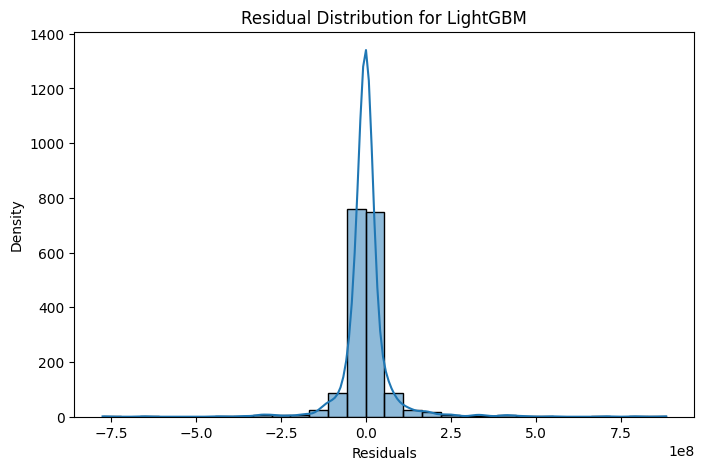

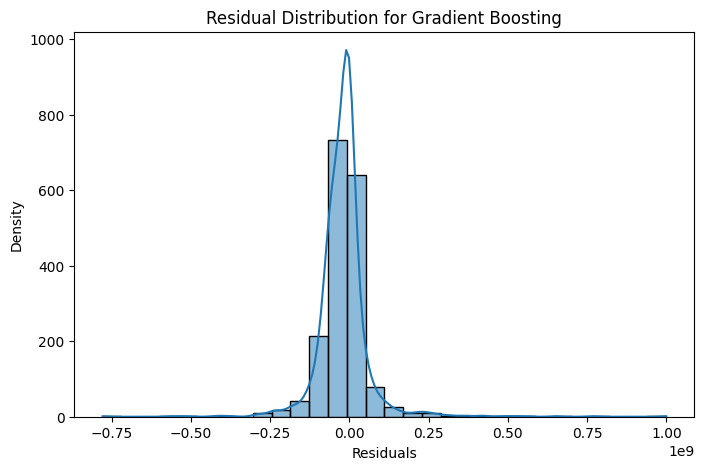

In [ ]:
import seaborn as sns

def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title(f"Residual Distribution for {model_name}")
    plt.show()

plot_residuals(y_test, y_pred_lgbm, "LightGBM")
# plot_residuals(y_test, y_pred_rf, "Random Forest")
plot_residuals(y_test, y_pred_gbr, "Gradient Boosting")


In [ ]:
def display_feature_importances(model, dataframe):
    # Get feature importance
    importance_df = pd.DataFrame({
        'Feature': dataframe.columns,
        'Importance': model.feature_importances_
    })

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the top most important features
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Top Feature Importances from {type(model).__name__}')
    plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
    plt.show()

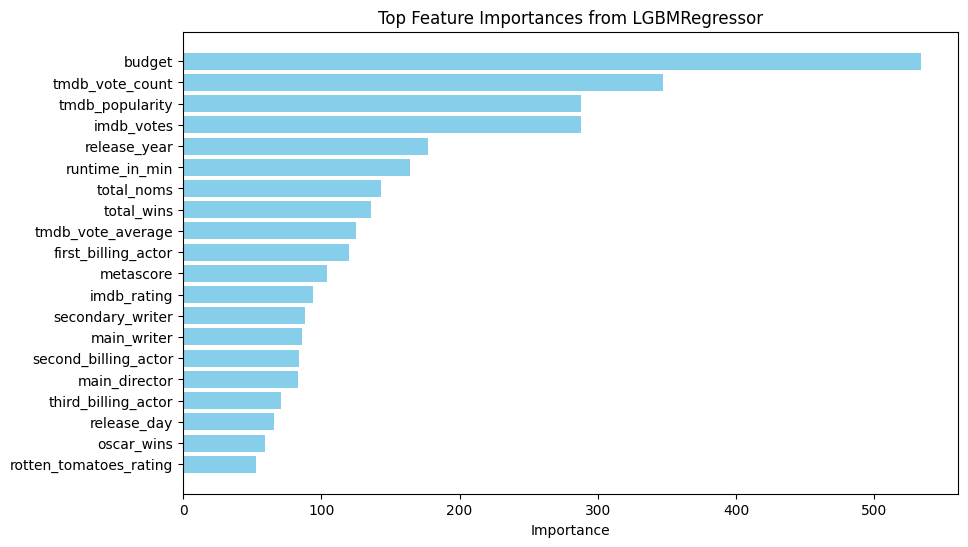

In [ ]:
display_feature_importances(best_lgbm, X_train_scaled)

In [ ]:
# display_feature_importances(best_rf, X_train_scaled)